In [1]:
import pandas as pd
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.master("local[4]").appName("ClusterShop").getOrCreate()

# set log level to Error
spark.sparkContext.setLogLevel("ERROR")

# Read the Excel file using Pandas
df_pandas = pd.read_excel("Online Retail.xlsx",na_values='')

# Convert the Pandas DataFrame to PySpark DataFrame 
df_spark = spark.createDataFrame(df_pandas)

23/04/18 02:39:14 WARN Utils: Your hostname, khaldon-LENOVO resolves to a loopback address: 127.0.1.1; using 192.168.1.2 instead (on interface wlp0s20f3)
23/04/18 02:39:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/18 02:39:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Show the DataFrame
df_spark.show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|2010-12-01 08:26:00|     7.65|   17850.0|United Kingdom|
|   536365|    21730|GLASS S

### Data Summary

In [3]:
# Describe the DataFrame
df_spark.describe().show()


+-------+------------------+------------------+--------------------+------------------+-----------------+----------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|        UnitPrice|CustomerID|    Country|
+-------+------------------+------------------+--------------------+------------------+-----------------+----------+-----------+
|  count|            541909|            541909|              541909|            541909|           541909|    541909|     541909|
|   mean|  559965.752026781|27623.240210938104|                 NaN|  9.55224954743324|4.611113626088897|       NaN|       null|
| stddev|13428.417280798658| 16799.73762842766|                 NaN|218.08115785023472|96.75985306117991|       NaN|       null|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|            -80995|        -11062.06|   12346.0|  Australia|
|    max|           C581569|                 m|   wrongly sold sets|             80995|          

## Explore the data

### Percentage of missing values in each column

In [4]:
# percentage of missing values in each column of the DataFrame
from pyspark.sql.functions import col, count, isnan, when
# get columns excluding 'InvoiceDate'
cols = [col for col in df_spark.columns if col != 'InvoiceDate']


# count missing values in each column as a percentage of the total number of values and total number of values in each column
df_spark.select([count(when(~isnan(c), c)).alias(c) for c in cols]).show()
df_spark.select([count(when(isnan(c), c)).alias(c) for c in cols]).show()

+---------+---------+-----------+--------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+---------+----------+-------+
|   541909|   541909|     540455|  541909|   541909|    406829| 541909|
+---------+---------+-----------+--------+---------+----------+-------+



+---------+---------+-----------+--------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+---------+----------+-------+
|        0|        0|       1454|       0|        0|    135080|      0|
+---------+---------+-----------+--------+---------+----------+-------+



## Clean the data

In [5]:
import math

# filter out the missing values using map 
df_spark_filtered = df_spark.rdd.map(lambda x: x if not math.isnan(x['CustomerID'])  else None).filter(lambda x: x is not None).toDF()
df_spark_filtered.select([count(when(isnan(c), c)).alias(c) for c in cols]).show()


+---------+---------+-----------+--------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+---------+----------+-------+
|        0|        0|          0|       0|        0|         0|      0|
+---------+---------+-----------+--------+---------+----------+-------+



## Percentage of Cancelled Orders

In [6]:

unique_invoice = df_spark_filtered.select('InvoiceNo').distinct().count()
cancelled_invoice_count = df_spark_filtered.filter(df_spark_filtered['InvoiceNo'].startswith('C')).select('InvoiceNo').distinct().count()

# percentage of cancelled invoices
print("Percentage of cancelled invoices: ", (cancelled_invoice_count/unique_invoice)*100)

Percentage of cancelled invoices:  16.466876971608833


In [7]:

from pyspark.sql.functions import col
from pyspark.sql.functions import round
from pyspark.sql.functions import month

# create a new column called TotalCost
df_spark_filtered = df_spark_filtered.withColumn("TotalCost", col("Quantity") * col("UnitPrice"))

# round the TotalCost column to 2 decimal places
df_spark_filtered = df_spark_filtered.withColumn("TotalCost", round(df_spark_filtered.TotalCost, 2))
df_spark_filtered.show()




+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+---------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|TotalCost|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+---------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|     15.3|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|    20.34|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|     22.0|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|    20.34|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|    20.34|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|2010-

In [8]:
# Basket size
basket_price = df_spark_filtered.groupBy('CustomerID','InvoiceNo').agg({'TotalCost': 'sum'}).withColumnRenamed('sum(TotalCost)', 'TotalCost').sort('CustomerID')
basket_price.show()

+----------+---------+------------------+
|CustomerID|InvoiceNo|         TotalCost|
+----------+---------+------------------+
|   12346.0|   541431|           77183.6|
|   12346.0|  C541433|          -77183.6|
|   12347.0|   537626|            711.79|
|   12347.0|   542237|            475.39|
|   12347.0|   573511|1294.3200000000002|
|   12347.0|   549222|            636.25|
|   12347.0|   556201|            382.52|
|   12347.0|   562032|            584.91|
|   12347.0|   581180|224.82000000000002|
|   12348.0|   541998|227.43999999999997|
|   12348.0|   539318| 892.8000000000001|
|   12348.0|   548955|             367.0|
|   12348.0|   568172|             310.0|
|   12349.0|   577609|           1757.55|
|   12350.0|   543037|334.40000000000003|
|   12352.0|   567505|            366.25|
|   12352.0|   547390|160.32999999999998|
|   12352.0|   544156|296.49999999999994|
|   12352.0|   568699|            266.25|
|   12352.0|  C545329|            -463.8|
+----------+---------+------------

+-------+------------------+
|summary|         TotalCost|
+-------+------------------+
|  count|             22190|
|   mean|374.04532717440236|
| stddev|2018.4828692051483|
|    min|         -168469.6|
|    max|          168469.6|
+-------+------------------+



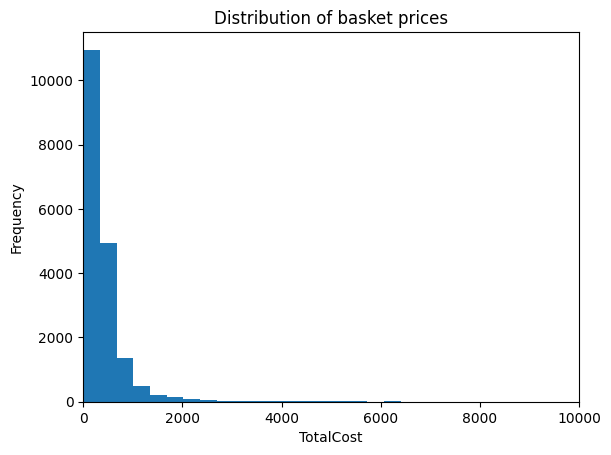

In [9]:
# Distribution of prices of baskets
basket_price.select('TotalCost').describe().show()

# construct a histogram of the basket prices
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# convert the PySpark DataFrame to Pandas DataFrame
basket_price_pd = basket_price.toPandas()

# plot the histogram
fig, ax = plt.subplots()
ax.hist(basket_price_pd['TotalCost'], bins=1000)
ax.set_xlabel('TotalCost')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of basket prices')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
ax = plt.gca()
ax.set_xlim([0, 10000])
plt.show()




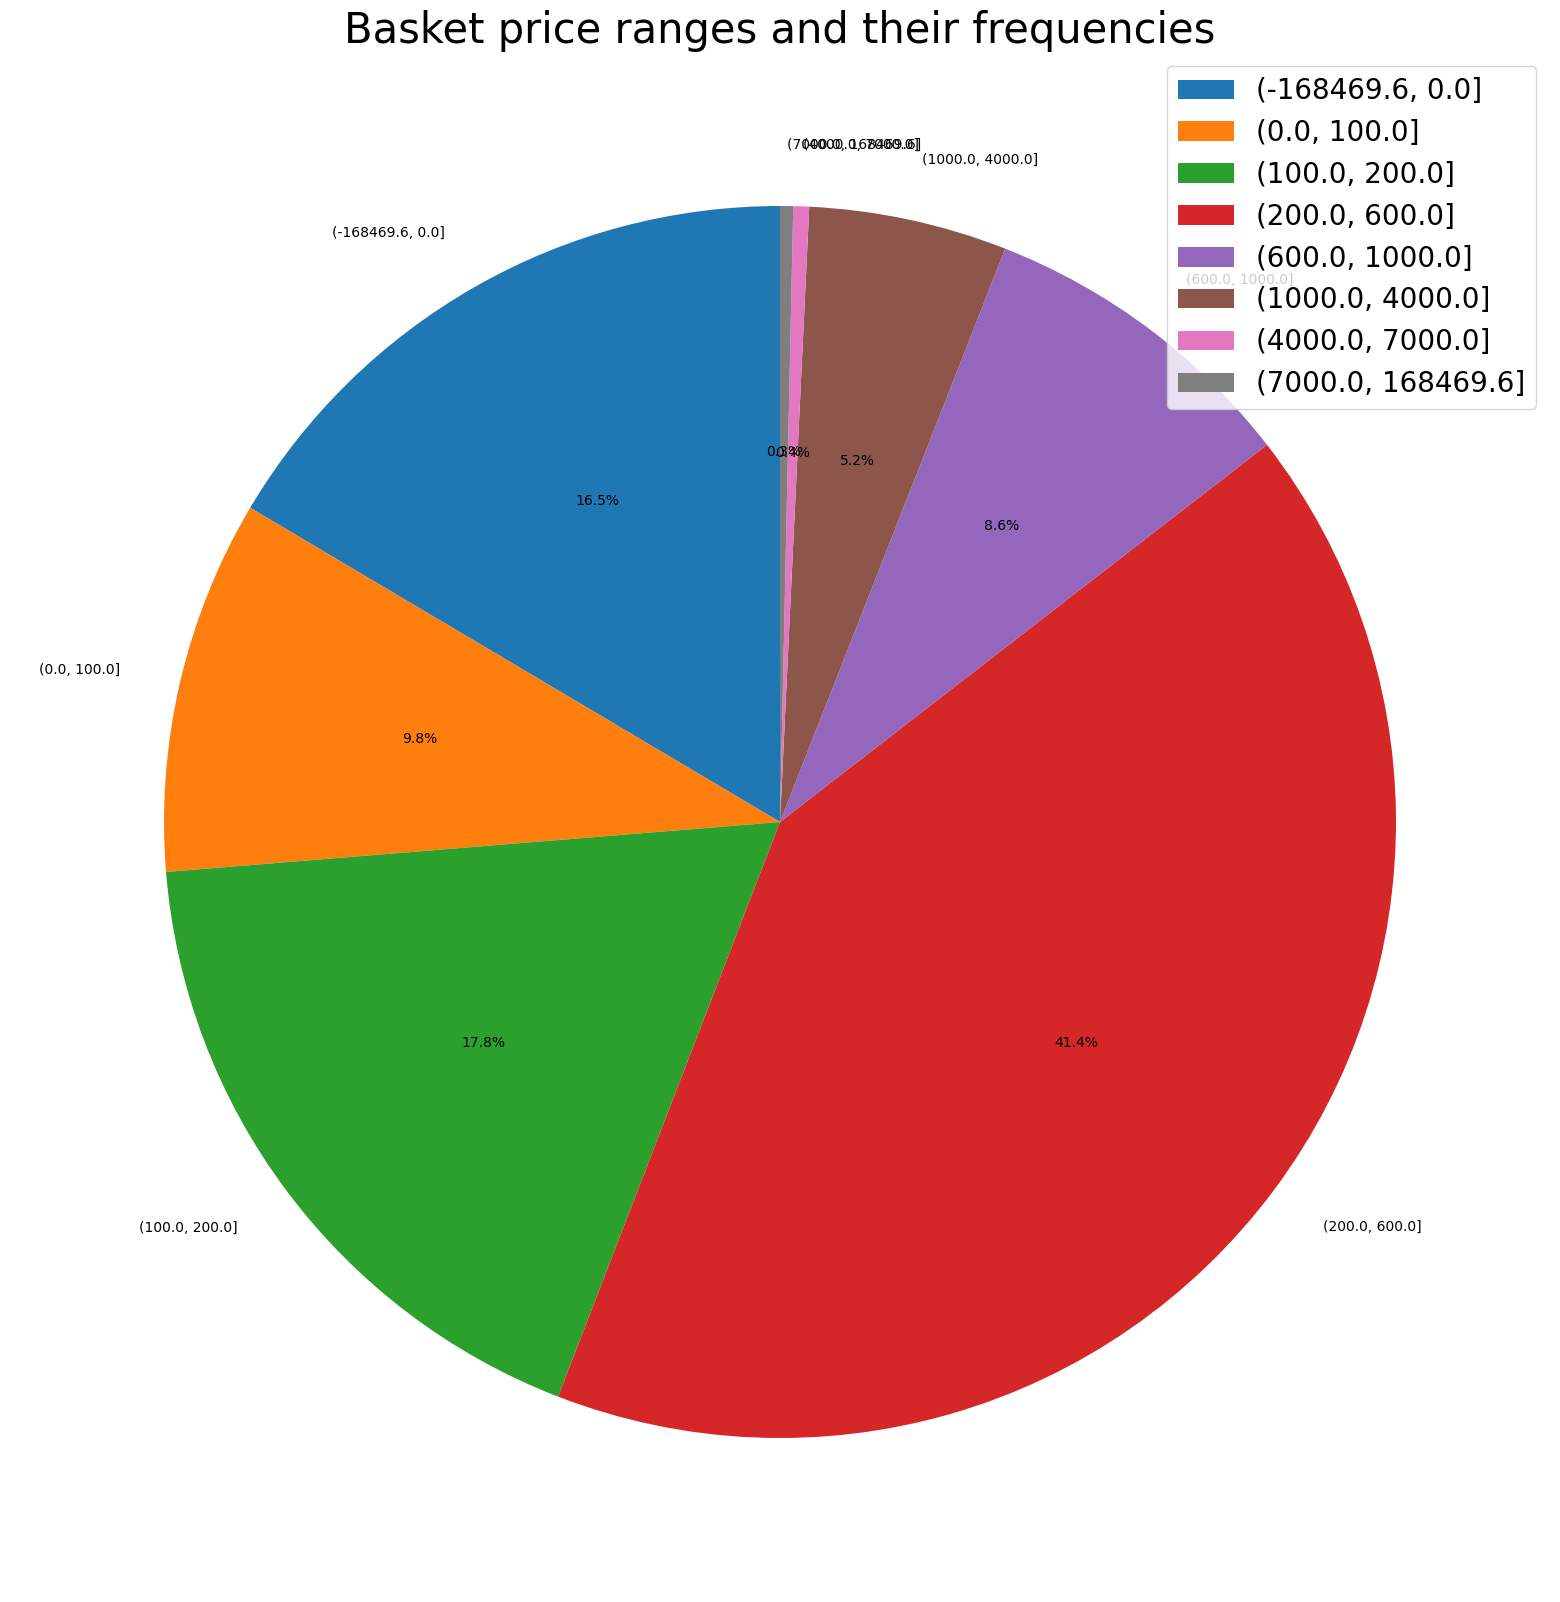

In [10]:
# construct ranges for the basket prices and count the number of baskets in each range
ranges = [-168469.6,0, 100, 200, 600, 1000, 4000, 7000,168469.6]
basket_price_range = basket_price_pd.groupby(pd.cut(basket_price_pd['TotalCost'], ranges)).count()
basket_price_range

# plot pie chart of the basket ranges and their frequencies
ax, fig = plt.subplots(figsize=(20, 20))
# plot pie chart
plt.pie(basket_price_range['TotalCost'], labels=basket_price_range.index, autopct='%1.1f%%', startangle=90)
# title
plt.title('Basket price ranges and their frequencies', fontsize=30)
# legend
plt.legend(basket_price_range.index, loc='upper right', fontsize=20)
plt.show()


### Analyze description Column

In [11]:
import nltk
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, StructType, StructField

is_noun = lambda pos: pos[:2] == 'NN'
# Define a user-defined function (UDF) to extract nouns from a sentence
def extract_nouns(sentence):
    if sentence is None:
        return []
    else:
        stemmer = nltk.stem.SnowballStemmer("english")
        tokenized = nltk.word_tokenize(sentence.lower())
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
     

        return [stemmer.stem(noun) for noun in nouns]

# Register the UDF with PySpark SQL
extract_nouns_udf = udf(extract_nouns, ArrayType(StringType()))

# Define the schema for the output of the keywords_inventory function
keywords_schema = StructType([
    StructField("category_key", StringType(), True),
    StructField("keywords_roots", StringType(), True),
    StructField("keywords_select", StringType(), True),
    StructField("count_keywords", StringType(), True)
])

def keywords_inventory(dataframe, colonne='Description'):
    # Apply the extract_nouns UDF to the specified column and create a new column with the extracted nouns
    dataframe = dataframe.withColumn("nouns", extract_nouns_udf(dataframe[colonne]))
    
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys = []
    count_keywords = dict()
    
    for row in dataframe.select("nouns").collect():
        nouns = row[0]
        
        for t in nouns:
            racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k
                    min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
    
    # Convert the results to PySpark DataFrame and return
    result = [[category_keys[i], list(keywords_roots.keys())[i], keywords_select[list(keywords_roots.keys())[i]], count_keywords[list(keywords_roots.keys())[i]]] for i in range(len(category_keys))]
    return spark.createDataFrame(result, schema=keywords_schema)


# get unique products describtions
df_products_desc = df_spark_filtered.select('Description').distinct()

# Apply the keywords_inventory function to the dataframe
keywords = keywords_inventory(df_products_desc)

# Display the number of keywords
print("Number of keywords: ", keywords.count())

Number of keywords:  1482


+------------+--------------+---------------+--------------+
|category_key|keywords_roots|keywords_select|count_keywords|
+------------+--------------+---------------+--------------+
|       heart|         heart|          heart|           267|
|      vintag|        vintag|         vintag|           211|
|         set|           set|            set|           206|
|        pink|          pink|           pink|           189|
|         bag|           bag|            bag|           165|
|         box|           box|            box|           155|
|       glass|         glass|          glass|           149|
|    christma|      christma|       christma|           137|
|      design|        design|         design|           128|
|       candl|         candl|          candl|           121|
|      holder|        holder|         holder|           120|
|      flower|        flower|         flower|           120|
|       decor|         decor|          decor|           109|
|       metal|         m

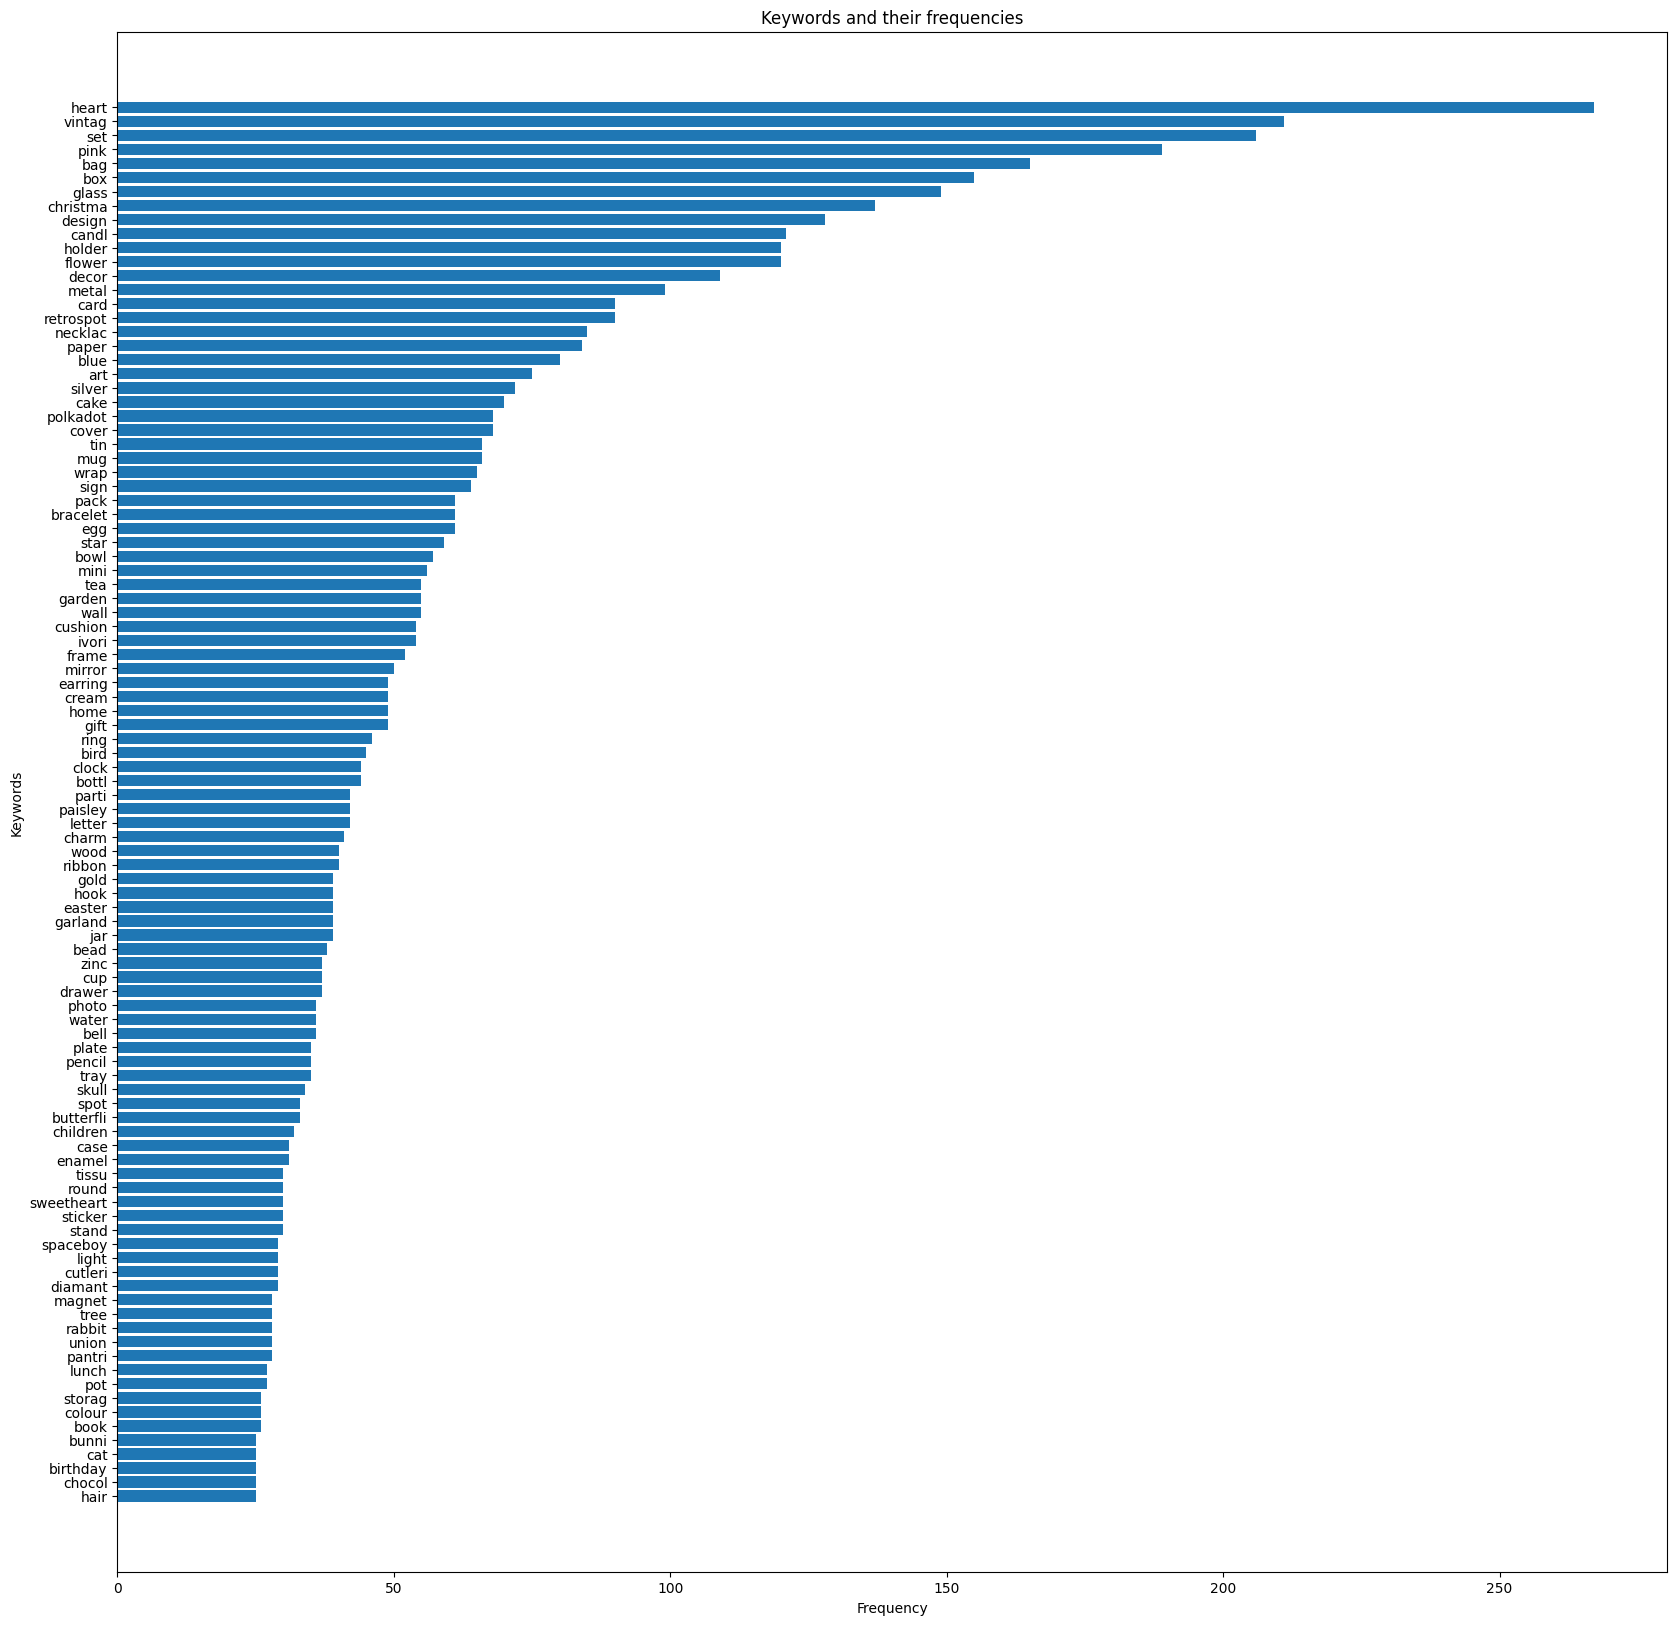

In [12]:
# sort the keywords by their frequencies after converting the count_keywords column to integer  
keywords = keywords.withColumn("count_keywords", keywords["count_keywords"].cast("int")).sort("count_keywords", ascending=False)
keywords.show()

# plot the histogram of the keywords frequencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# convert the PySpark DataFrame to Pandas DataFrame
keywords_pd = keywords.toPandas()

# plot the horizontal bar chart
fig, ax = plt.subplots(figsize=(20, 20))
ax.barh(keywords_pd['category_key'][:100], keywords_pd['count_keywords'][:100])
ax.set_xlabel('Frequency')
ax.set_ylabel('Keywords')
ax.set_title('Keywords and their frequencies')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
ax = plt.gca()
ax.invert_yaxis()
plt.show()



In [13]:
# consider only the keywords with frequency greater than 20
keywords_filtered = keywords.filter(keywords['count_keywords'] > 15)

print("Number of keywords: ", keywords_filtered.count())

Number of keywords:  162


In [14]:
# # one-hot encode the description column using the keywords_filtered DataFrame
# # if a keyword is present in the description, then the corresponding column is set to 1, otherwise it is set to 0
# from pyspark.sql.types import IntegerType
# matrix = keywords_filtered.select('category_key').toPandas().values.tolist()
# matrix = [item for sublist in matrix for item in sublist]

# def one_hot_encode(row):
#     if row is None:
#         return [0] * len(matrix)
#     else:
#         stemmer = nltk.stem.SnowballStemmer("english")
#         tokenized = nltk.word_tokenize(row.lower())
#         nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
#         nouns = [stemmer.stem(noun) for noun in nouns]
#         return [1 if noun in nouns else 0 for noun in matrix]
    
# # Register the UDF with PySpark SQL
# one_hot_encode_udf = udf(one_hot_encode, ArrayType(IntegerType()))

# # Apply the one_hot_encode_udf UDF to the Description column and create a new column with the one-hot encoded values
# df_spark_filtered = df_spark_filtered.withColumn("one_hot_encoded", one_hot_encode_udf(df_spark_filtered['Description']))



In [15]:
# one_hot_encoded = df_spark_filtered.select('one_hot_encoded').toPandas().values.tolist()

# one_hot_encoded = [item for sublist in one_hot_encoded for item in sublist]

# print("shape of one-hot encoded vectors: ", len(one_hot_encoded[0]))

In [16]:
# # cluster the one-hot encoded vectors using KMeans
# from sklearn.cluster import KMeans
# kmeans = KMeans(init='k-means++', n_clusters = 5, n_init=30)
# kmeans.fit(one_hot_encoded)

# # get the cluster labels
# labels = kmeans.labels_

# # get the cluster centers
# centers = kmeans.cluster_centers_

# print("shape of cluster centers: ", centers.shape)

In [17]:
# df_spark_filtered_ = df_spark_filtered.toPandas()
# df_spark_filtered_['cluster'] = labels
# df_spark_filtered_.head()

In [18]:

# # convert the Pandas DataFrame to PySpark DataFrame
# df_spark_filtered_ = spark.createDataFrame(df_spark_filtered_)

# # get unique_products describtions
# df_products_desc = df_spark_filtered_.select('StockCOde', 'cluster').distinct()

# # get number of products in each cluster
# df_products_desc.groupby('cluster').count().show()


In [19]:
# clusters = kmeans.predict(one_hot_encoded)
# pd.Series(clusters).value_counts()

In [20]:
count_keywords = keywords_pd['count_keywords'].values.tolist()
keywords_select = keywords_pd['category_key'].values.tolist()

count_keywords = dict(enumerate(count_keywords))
keywords_select = dict(enumerate(keywords_select))

list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)

print("Number of products: ", len(list_products))

liste_produits = df_spark_filtered.select('Description').toPandas()['Description'].values.tolist()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
    
    
    

Number of products:  193


/tmp/ipykernel_5354/1224167222.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
/tmp/ipykernel_5354/1224167222.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
/tmp/ipykernel_5354/1224167222.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

In [63]:
# group the stock code and take mean of unit price
df_spark_filtered_ = df_spark_filtered.groupby('Description').agg({'UnitPrice': 'mean'}).withColumnRenamed('avg(UnitPrice)', 'UnitPrice')
# Divide Products based on unit price ranges (0-1,1-2,2-4,4-10,10-20,20+)
df_spark_filtered_ = df_spark_filtered_.withColumn("UnitPriceRangeOneHot", when(df_spark_filtered_["UnitPrice"] < 1, "[1,0,0,0,0,0]")
                                                    .when((df_spark_filtered_["UnitPrice"] >= 1) & (df_spark_filtered_["UnitPrice"] < 2), "[0,1,0,0,0,0]")
                                                    .when((df_spark_filtered_["UnitPrice"] >= 2) & (df_spark_filtered_["UnitPrice"] < 4), "[0,0,1,0,0,0]")
                                                    .when((df_spark_filtered_["UnitPrice"] >= 4) & (df_spark_filtered_["UnitPrice"] < 10), "[0,0,0,1,0,0]")
                                                    .when((df_spark_filtered_["UnitPrice"] >= 10) & (df_spark_filtered_["UnitPrice"] < 20), "[0,0,0,0,1,0]")
                                                    .otherwise("[0,0,0,0,0,1]"))



df_spark_filtered_ = df_spark_filtered_.select('Description', 'UnitPriceRangeOneHot').distinct().sort('Description')
# df_spark_filtered_.show()

# get number of products in each price range sorted
df_spark_filtered_.groupby('UnitPriceRangeOneHot').count().sort('UnitPriceRangeOneHot').show()


+--------------------+-----+
|UnitPriceRangeOneHot|count|
+--------------------+-----+
|       [0,0,0,0,0,1]|   38|
|       [0,0,0,0,1,0]|  120|
|       [0,0,0,1,0,0]|  785|
|       [0,0,1,0,0,0]|  976|
|       [0,1,0,0,0,0]| 1016|
|       [1,0,0,0,0,0]|  961|
+--------------------+-----+



In [ ]:
one_hot_encoded  = df_spark_filtered_.select('UnitPriceRangeOneHot').toPandas()['UnitPriceRangeOneHot'].values.tolist()

# convert the list of strings to matrix
one_hot_encoded = [eval(item) for item in one_hot_encoded]


/home/khaldon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.4841358117587545


/home/khaldon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.7208522477747781


/home/khaldon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.9280643600334199


/home/khaldon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.9812053165116321


/home/khaldon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 1.0


/home/khaldon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/khaldon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 7 The average silhouette_score is : 1.0


/home/khaldon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/khaldon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 8 The average silhouette_score is : 1.0


/home/khaldon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/khaldon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 9 The average silhouette_score is : 1.0


/home/khaldon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/khaldon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 10 The average silhouette_score is : 1.0


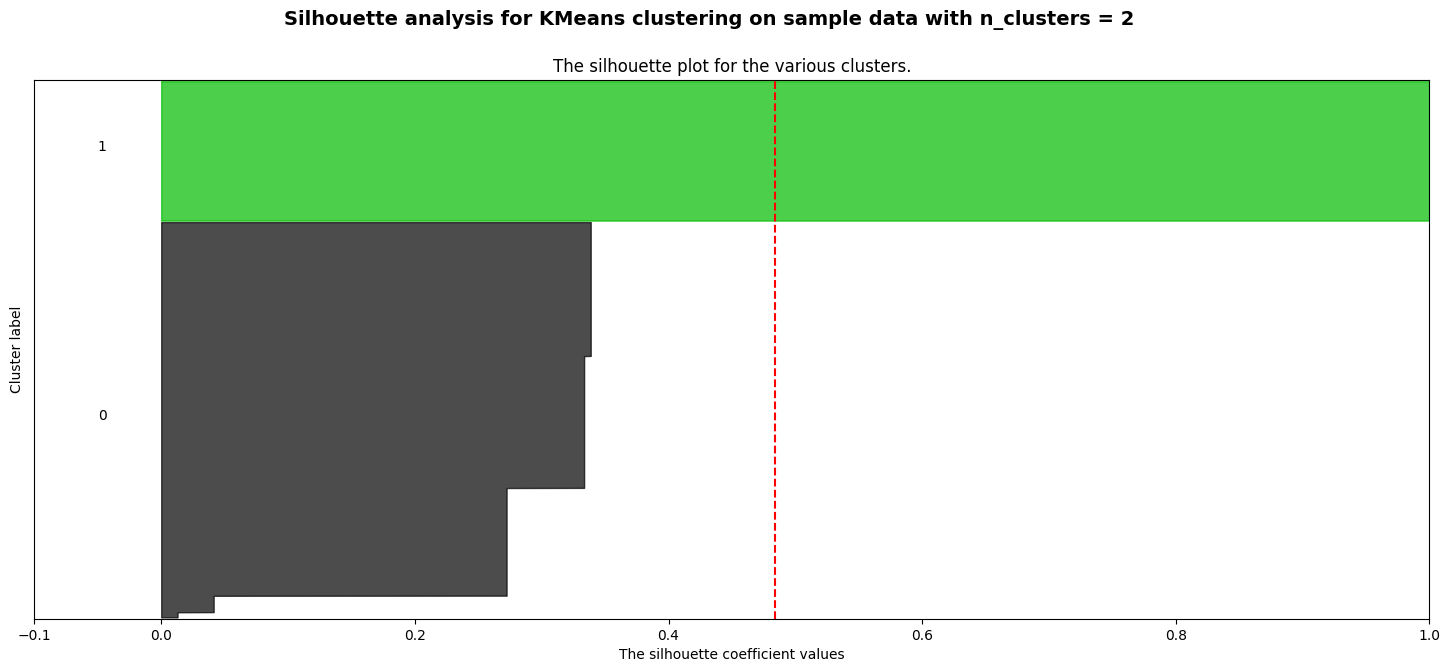

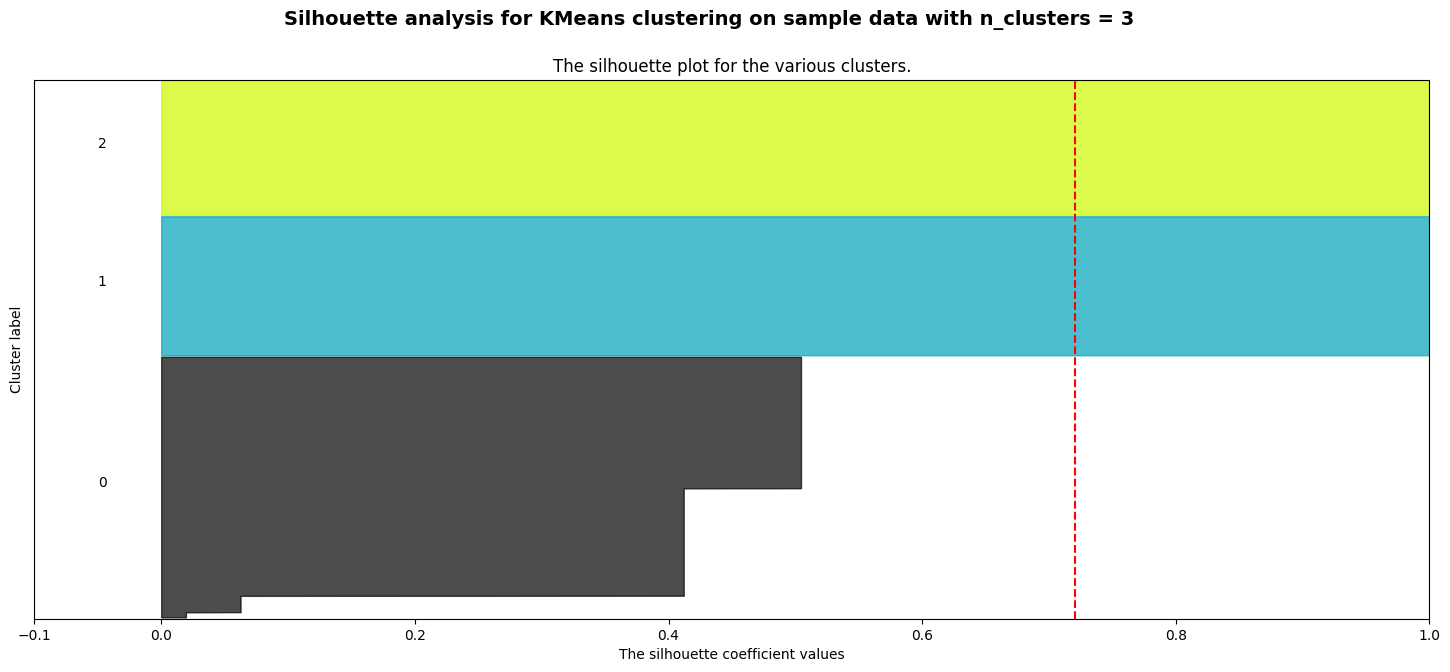

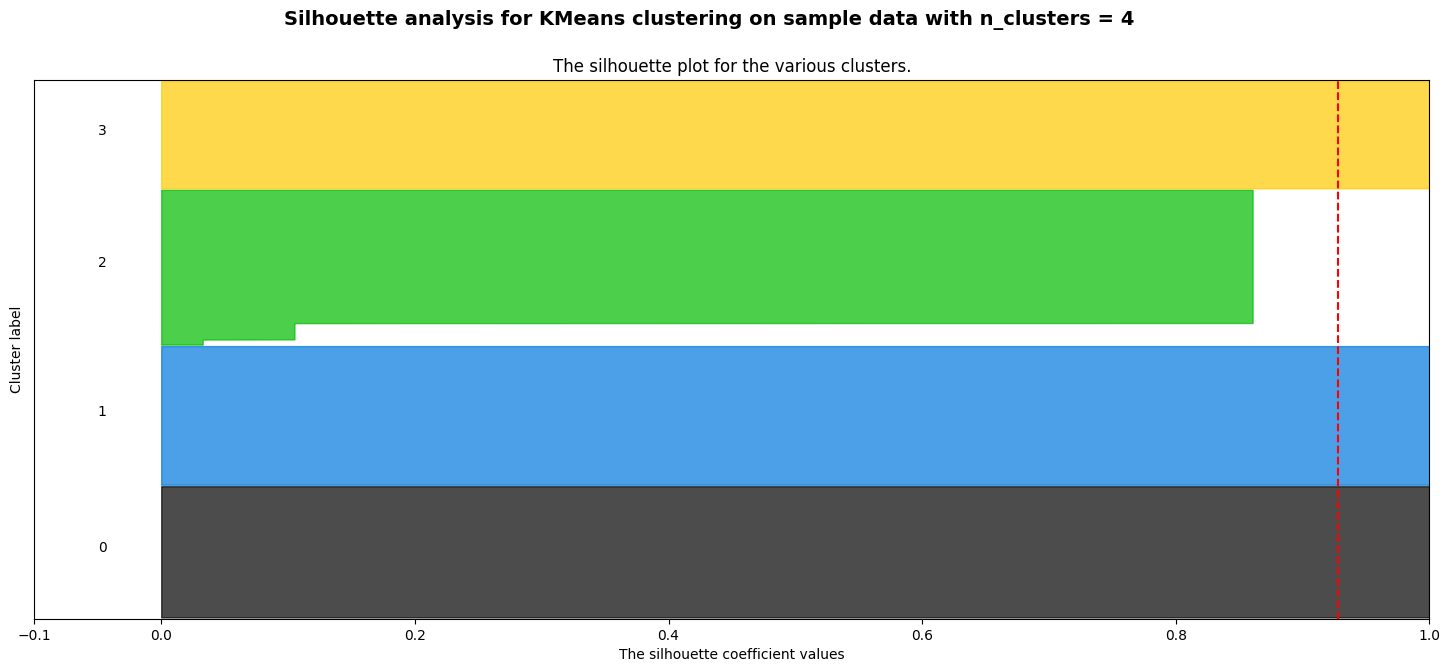

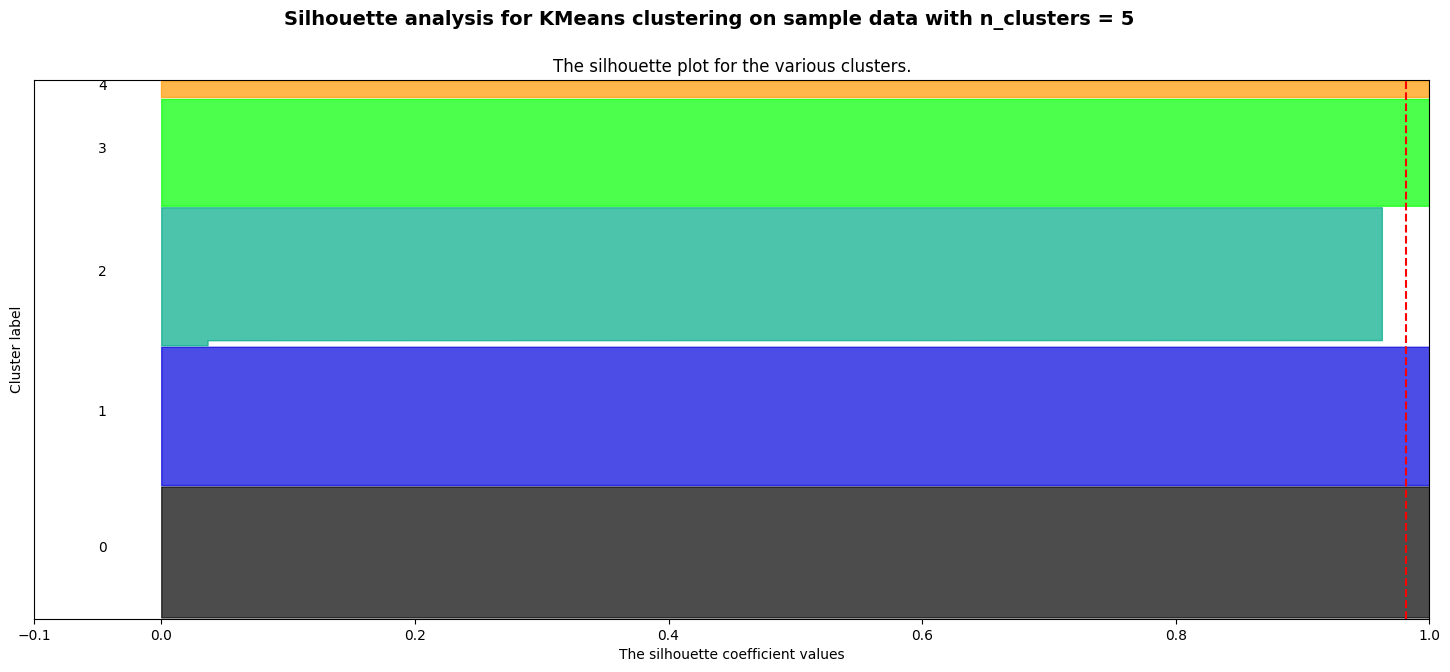

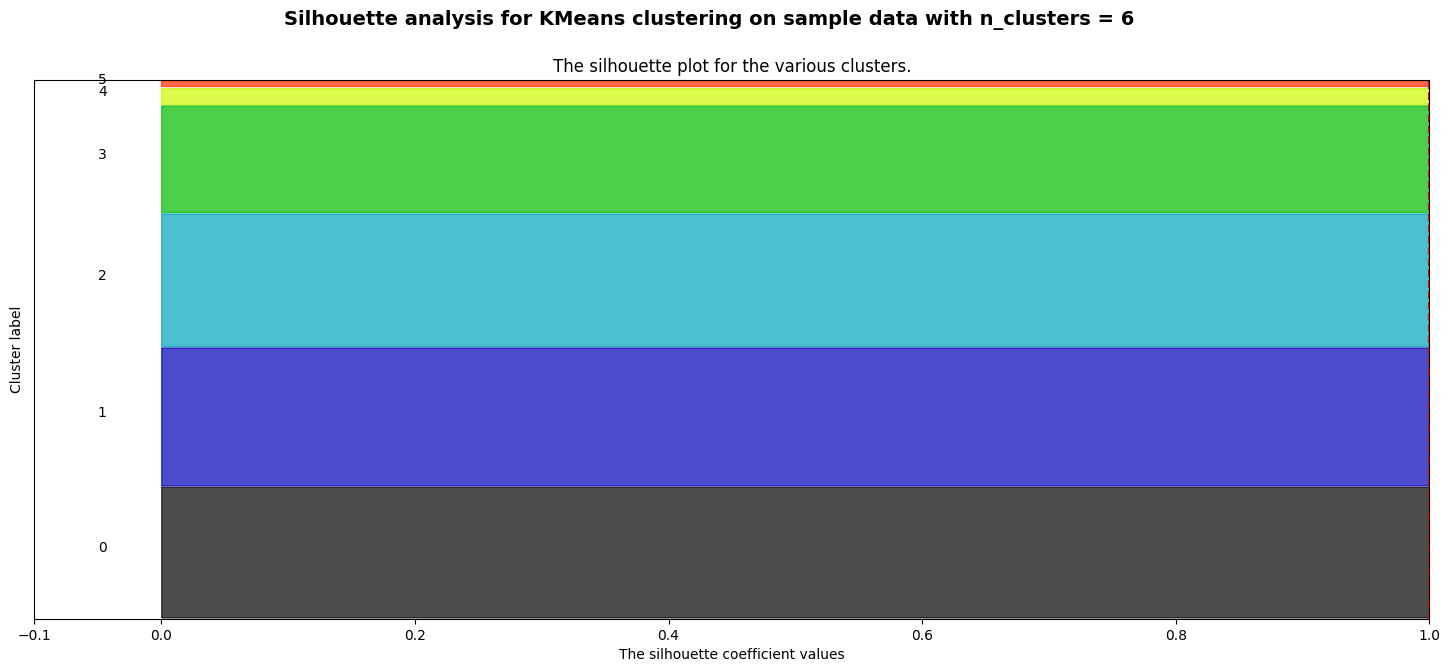

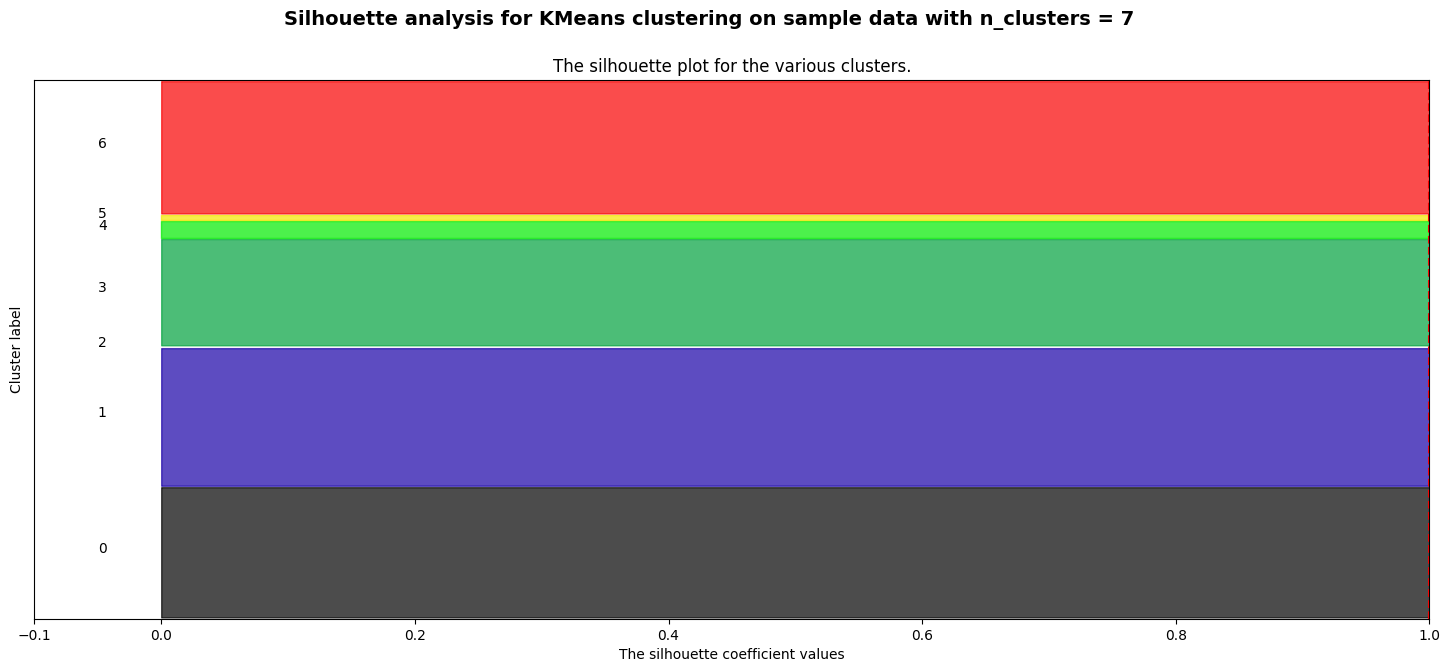

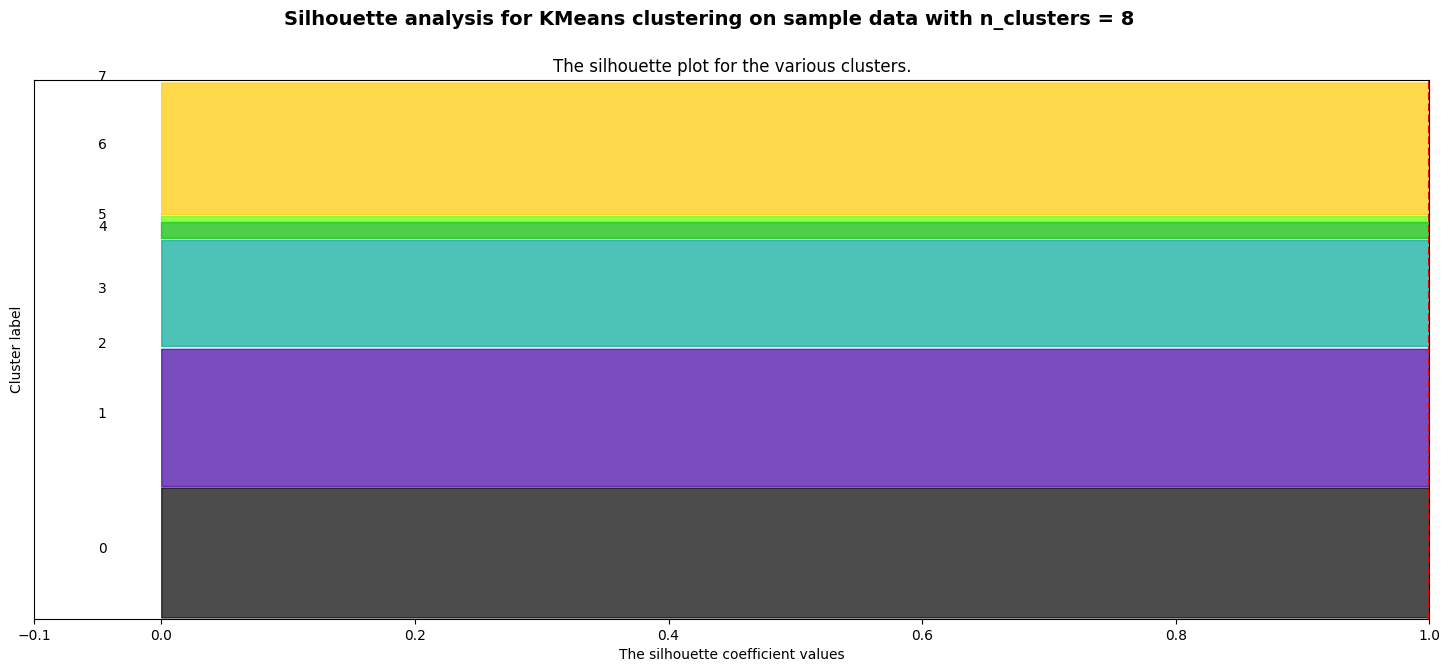

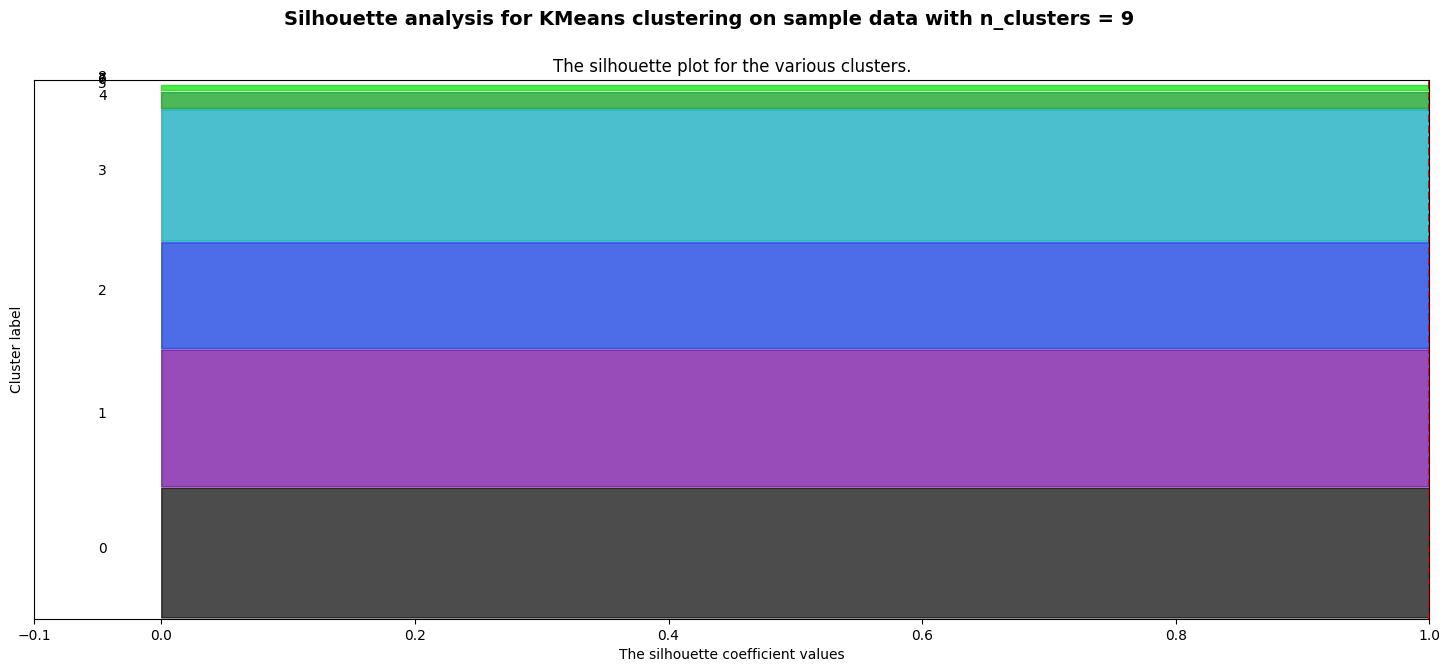

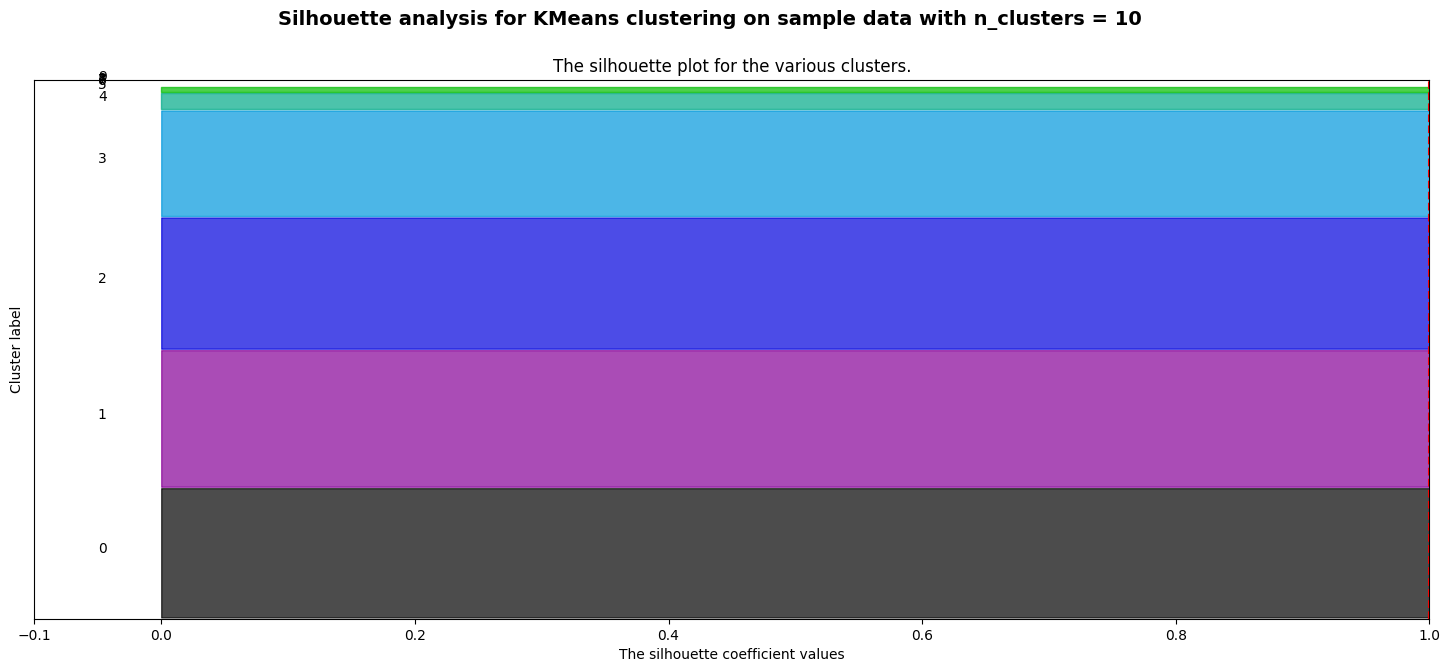

In [68]:
# In order to have an insight on the quality of the classification,
# we can represent the silhouette scores of each element of the different clusters

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(one_hot_encoded) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(one_hot_encoded)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(one_hot_encoded, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(one_hot_encoded, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % n_clusters),
                    fontsize=14, fontweight='bold')

plt.show()

In [69]:

# cluster the one-hot encoded vectors using KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(init='k-means++', n_clusters = 6, n_init=30)
kmeans.fit(one_hot_encoded)

# get the cluster labels
labels = kmeans.labels_
clusters = kmeans.predict(one_hot_encoded)
pd.Series(clusters).value_counts()

2    1016
1     976
0     961
3     785
4     120
5      38
dtype: int64